# Importing libraries and cleaned dataset

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

import holidays 

from statsmodels.tools.eval_measures import rmse
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose


from functions import prophet_model, df_prophet_prep, outlier_scaling, metrics_calc_clusters,prophet_model_with_clusters,prophet_model_per_product
from functions import prophet_model_per_product_SELECTED_MODEL_returns_forecast, prophet_model_SELECTED_MODEL_returns_forecast, prophet_model_per_product_CLUSTER_SELECTED_MODEL_returns_forecast

import logging
import pickle
import warnings

logging.getLogger('prophet').setLevel(logging.ERROR)
warnings.filterwarnings('ignore')

Importing plotly failed. Interactive plots will not work.


**Original Dataset**:

Chen,Daqing. (2015). Online Retail. UCI Machine Learning Repository. https://archive.ics.uci.edu/dataset/352/online+retail

In [2]:
# Importing dataset, clean and filtered with clusters from the notebook 03_ML_clustering
# the filters on are: only actual products, only UK (90% of the orders), dropping NaN customerID
# At a later stage, I can solve the NaN in CustomerID by building a ML model to predict their Label based on the order(from InvoiceNo) characteristics
file_path = '../data/data_filtered_with_clusters.csv'

df = pd.read_csv(file_path, dtype={'InvoiceNo': 'O','StockCode': 'O','Description': 'O',
                                   'Quantity': 'int64','UnitPrice': 'float64',
                                   'CustomerID': 'Int64','Country': 'O'}, parse_dates=['InvoiceDate'])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Label
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.95,17850,United Kingdom,17.7,2
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.75,17850,United Kingdom,22.5,2
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,4.15,17850,United Kingdom,33.2,2
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.75,17850,United Kingdom,22.5,2
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,4.25,17850,United Kingdom,25.5,2


# Feature Engineering

### Scaling outliers

I know from the EDA, shown in the previous notebooks, **two outliers** with huge difference in scale. I am going to do scaling to a range, scaling them to highest next value (after these two).

In [3]:
# Scaling within a range, updating the Quantity and accordingly the TotalPrice
df = outlier_scaling(df)

### Date column

Adding new column for the date without time.

In [4]:
# New date column without time
df['InvoiceDate_noTime'] = df.InvoiceDate.dt.normalize()

### Removing features that will not be used

I will be using StockCode, Quantity, Date and Labelfor my model. 

In [5]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'TotalPrice', 'Label',
       'InvoiceDate_noTime'],
      dtype='object')

In [6]:
df.drop(columns=['InvoiceNo','Description', 'InvoiceDate','UnitPrice', 
                 'CustomerID', 'Country', 'TotalPrice'],inplace=True)
df.rename(columns={'InvoiceDate_noTime':'InvoiceDate'}, inplace=True)
df.head()

,StockCode,Quantity,Label,InvoiceDate
0,85123A,6,2,2010-12-01
1,71053,6,2,2010-12-01
2,84406B,8,2,2010-12-01
3,84029G,6,2,2010-12-01
4,84029E,6,2,2010-12-01


# Top selling products

In [7]:
# the top selling products
products_top = df.groupby('StockCode')['Quantity'].sum().sort_values(ascending=False).index.tolist()
products_top

['84077',
 '22197',
 '85099B',
 '85123A',
 '84879',
 '22616',
 '17003',
 '21212',
 '22178',
 '21977',
 '15036',
 '22386',
 '23203',
 '21915',
 '22469',
 '84946',
 '85099F',
 '22086',
 '84755',
 '22693',
 '47566',
 '22492',
 '22151',
 '20725',
 '84991',
 '16014',
 '20668',
 '85099C',
 '71459',
 '23199',
 '21790',
 '23084',
 '21213',
 '21175',
 '22952',
 '22998',
 '23201',
 '21137',
 '21181',
 '22961',
 '21931',
 '23209',
 '84568',
 '22659',
 '22969',
 '22993',
 '84978',
 '21326',
 '20727',
 '23202',
 '84992',
 '21975',
 '22411',
 '84945',
 '21108',
 '22423',
 '23310',
 '22470',
 '79321',
 '22383',
 '20971',
 '20713',
 '21498',
 '22577',
 '23206',
 '21928',
 '21703',
 '21080',
 '21929',
 '21166',
 '84212',
 '22910',
 '21232',
 '22578',
 '20728',
 '20724',
 '22988',
 '84947',
 '21497',
 '22610',
 '21985',
 '22189',
 '22384',
 '23307',
 '23344',
 '22457',
 '82482',
 '85152',
 '84970S',
 '23077',
 '16045',
 '23301',
 '23166',
 '84347',
 '22865',
 '22699',
 '21733',
 '23232',
 '21891',
 '227

# Setting up

In [8]:
def df_prophet_prep(df, product):
    '''Function to prepare the dataframe for the prophet model.
    The dataframe is filtered to refer only to 1 product (one of the top selling ones).
    
    Receives as parameters: the dataframe that needs adjustment, and the product.
    
    Returns: updated dataframe.
    '''

    # Filtering with the top product, then removing stock code!
    df = df[df.StockCode == product].drop(columns='StockCode').reset_index(drop=True)
    
    
    # Adding rows for all dates, even if there is no data
    # Defining the known start and end dates of the dataset and creating dataframe with all the dates in between
    start_date = '2010-12-01'
    end_date = '2011-12-09'
    all_dates = pd.date_range(start=start_date, end=end_date, freq='D')
    all_dates_df = pd.DataFrame({'InvoiceDate': all_dates})
    
    # merging the date dataframe with the main dataframe
    merged_df = all_dates_df.merge(df, on='InvoiceDate', how='left').fillna(0)
    # and then grouping to make sure, I have only one line per day
    merged_df = merged_df.groupby('InvoiceDate')['Quantity'].sum().reset_index()

    
    # Renaming columns as needed for the prophet model
    for i in range(merged_df.shape[1]):
        if merged_df.iloc[:,i].dtypes =='<M8[ns]':
            merged_df.rename(columns={merged_df.columns[i]: "ds"}, inplace=True)
        else:
            merged_df.rename(columns={merged_df.columns[i]: "y"}, inplace=True)

    # making sure the column order is as needed for the prophet model
    merged_df = merged_df[['ds', 'y']] 

    
    return merged_df

In [9]:
# Dataframe for the top bestselling product
df_p0 = df_prophet_prep(df.drop(columns='Label'), products_top[0])
df_p0.head()

,ds,y
0,2010-12-01,0.0
1,2010-12-02,3264.0
2,2010-12-03,48.0
3,2010-12-04,0.0
4,2010-12-05,96.0


In [10]:
'''
def UK_holidays_prophet(df):
    Function to make a dataframe with holiday days, that has the same dates as the main file used to train the model.

    Parameters: dataframe to be trained

    Returns: holidays dataframe, with two columns 'holiday' and 'ds'
    

    # taking the holidays for UK
    uk_holidays = holidays.UnitedKingdom() 
    
    df_holidays = pd.DataFrame(df_p0.ds.copy())
    # new column with the name of the holiday
    df_holidays['holiday'] = [uk_holidays.get(df_holidays.loc[i,'ds'].date().strftime('%Y-%m-%d')) for i in range(df_holidays.shape[0])]

    # dropping None values
    df_holidays.dropna(subset='holiday', inplace=True)
    
    return df_holidays

df_p0_holidays = UK_holidays_prophet(df_p0)
'''

"\ndef UK_holidays_prophet(df):\n    Function to make a dataframe with holiday days, that has the same dates as the main file used to train the model.\n\n    Parameters: dataframe to be trained\n\n    Returns: holidays dataframe, with two columns 'holiday' and 'ds'\n    \n\n    # taking the holidays for UK\n    uk_holidays = holidays.UnitedKingdom() \n    \n    df_holidays = pd.DataFrame(df_p0.ds.copy())\n    # new column with the name of the holiday\n    df_holidays['holiday'] = [uk_holidays.get(df_holidays.loc[i,'ds'].date().strftime('%Y-%m-%d')) for i in range(df_holidays.shape[0])]\n\n    # dropping None values\n    df_holidays.dropna(subset='holiday', inplace=True)\n    \n    return df_holidays\n\ndf_p0_holidays = UK_holidays_prophet(df_p0)\n"

# Time Series Decomposition


Time series decomposition was performed to decompose the original time series data into its trend, seasonal, and residual components. From the decomposition, it was observed that there is a prominent weekly seasonality present in the data. Additionally, a minor monthly seasonality was noted in the trend component. These observations prompted the addition of a custom seasonality to the model to test its performance.


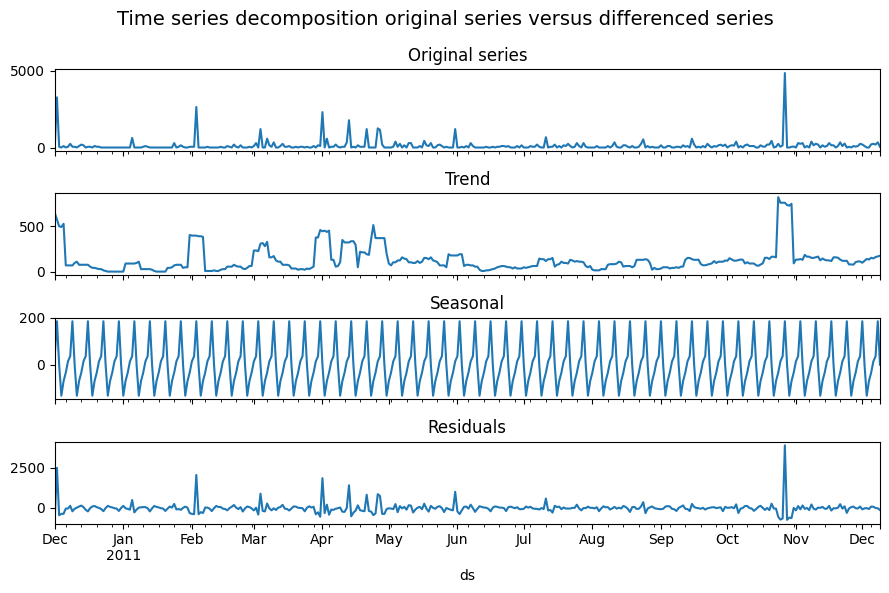

In [11]:
# Set 'ds' as the index
df_p0_tsd = df_p0.set_index('ds')

# Time series decomposition of original versus differenced series
res_decompose = seasonal_decompose(df_p0_tsd['y'], model='additive', extrapolate_trend='freq')

# Creating subplots
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(9, 6), sharex=True)

# Plotting the original series
res_decompose.observed.plot(ax=axs[0])
axs[0].set_title('Original series')
# Plotting the trend component
res_decompose.trend.plot(ax=axs[1])
axs[1].set_title('Trend')
# Plotting the seasonal component
res_decompose.seasonal.plot(ax=axs[2])
axs[2].set_title('Seasonal')
# Plotting the residuals component
res_decompose.resid.plot(ax=axs[3])
axs[3].set_title('Residuals')

# Adding titles
fig.suptitle('Time series decomposition original series versus differenced series', fontsize=14)

# Adjust layout
fig.tight_layout()

# Show the plot
plt.show()


In [12]:
# hyper parameter tuning
# with custom seasonality and without

# pipeline for all these
# model the clusters

# combine the cluster models

# Fitting the model

In [13]:
def prophet_train_test(df, days = 60):
    ''' Function to split dataset to train and test dataset.
    The prophet model will be supervised, and that's why I am splitting my dataset.

    Parameters: dataframe and option parameter number of days for the test dataframe.
                I hava taken as default 60, because my dataframe is around 12 months, so I am using 10 for train and 2 months for test dataset.

    Returns: train and test dataframe.
    '''
    
    # Splitting, train, test
    train = df.iloc[:len(df) - days]
    test = df.iloc[len(df) - days:]

    return train, test

In [14]:
# Splitting train and test set
df_p0_train, df_p0_test = prophet_train_test(df_p0)

# Fitting model
m_p0 = Prophet()
m_p0.add_country_holidays(country_name='UK')
m_p0.fit(df_p0_train)

# Predicting
forecast = m_p0.predict(df_p0[['ds']])

17:45:25 - cmdstanpy - INFO - Chain [1] start processing
17:45:25 - cmdstanpy - INFO - Chain [1] done processing


In [15]:
m_p0.train_holiday_names # checking which holidays are included

0                         Good Friday
1                             May Day
2                 Spring Bank Holiday
3                      New Year's Day
4                       Christmas Day
5            Christmas Day (observed)
6                          Boxing Day
7               Boxing Day (observed)
8    Wedding of William and Catherine
9           New Year's Day (observed)
dtype: object

<Axes: title={'center': 'Actual vs Forecast'}, xlabel='ds'>

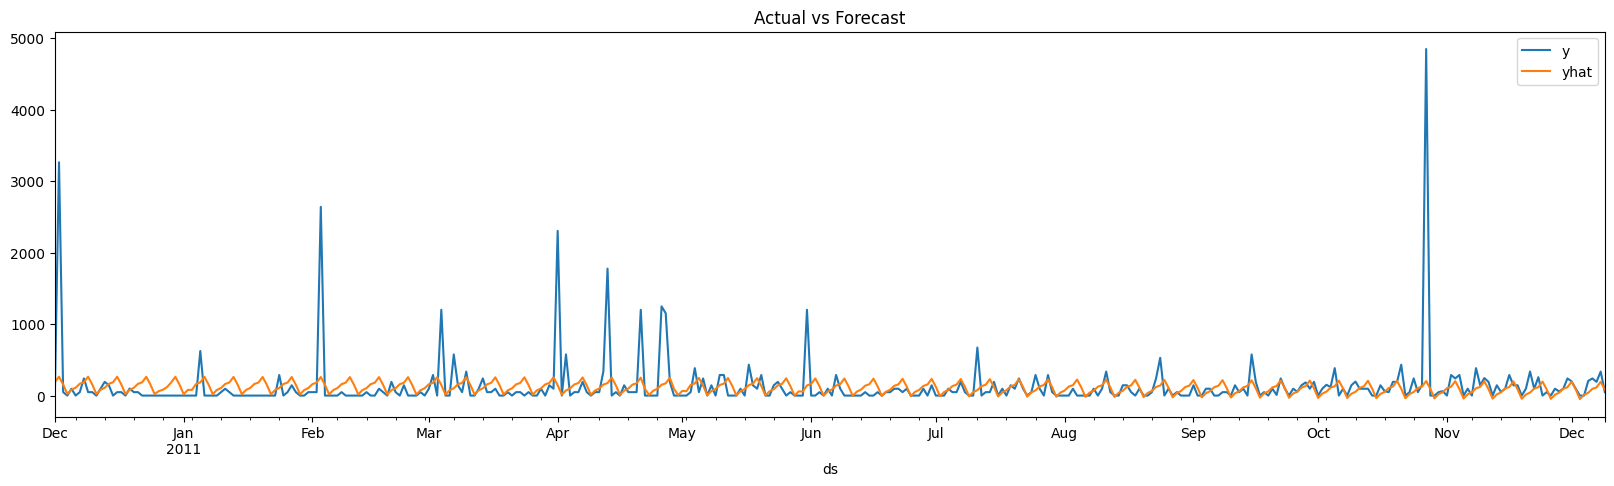

In [16]:
# plotting the actual and forecast values

ax = (df_p0.plot(x='ds',y='y',figsize=(20,5),title='Actual Vs Forecast'))
forecast.plot(x='ds',y='yhat',figsize=(20,5),title='Actual vs Forecast', ax=ax)

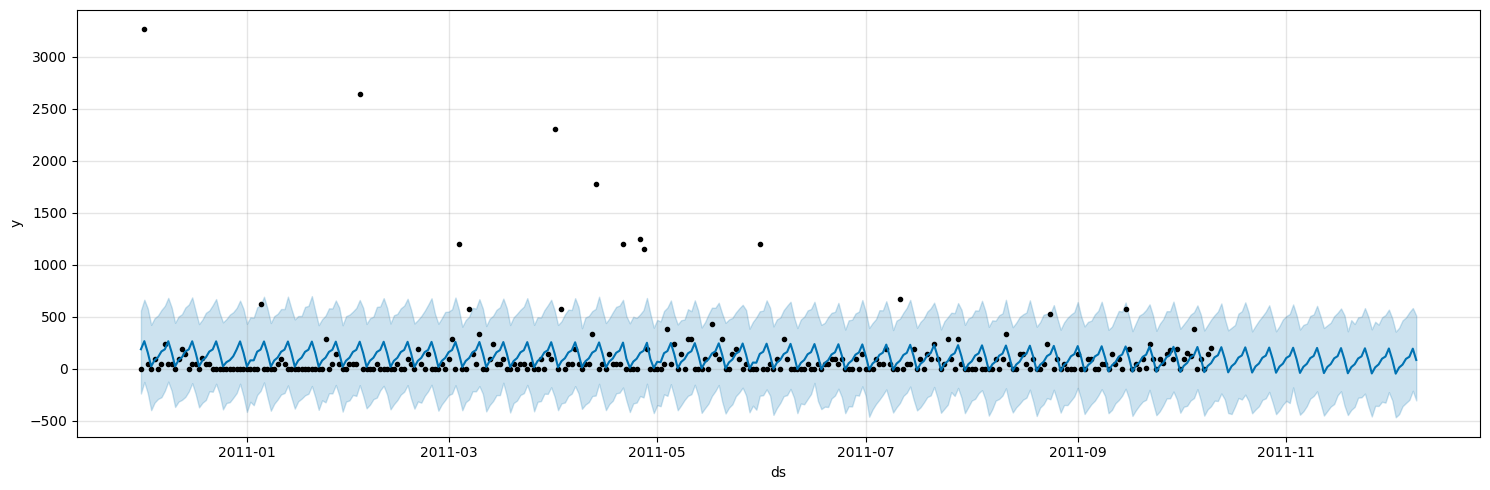

In [17]:
# Plotting the generated forecast
fig1 = m_p0.plot(forecast, uncertainty=True, figsize=(15,5))

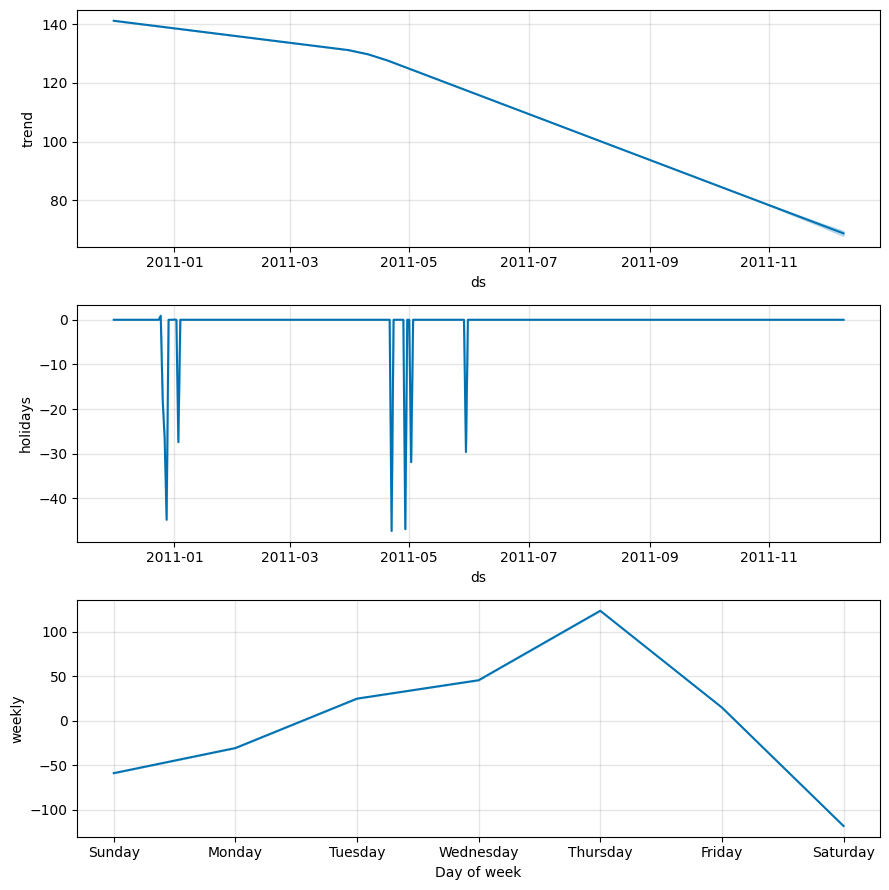

In [18]:
fig2 = m_p0.plot_components(forecast)

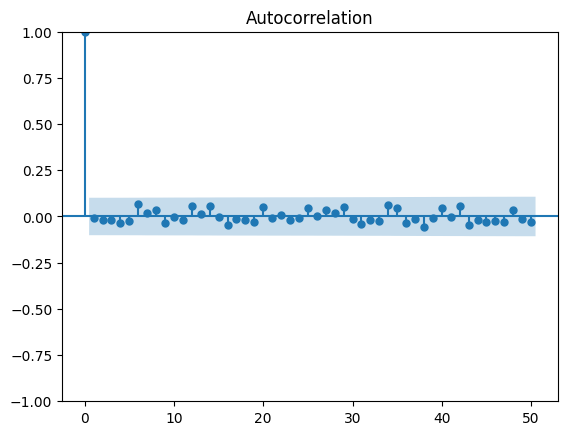

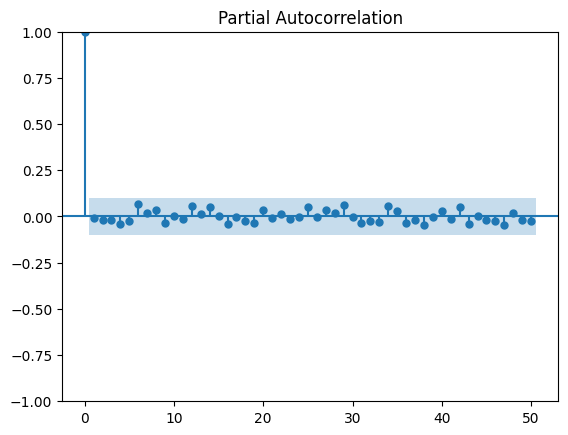

In [20]:
# Calculate autocorrelation and partial autocorrelation
lag_acf = plot_acf(df_p0['y'], lags=50)
lag_pacf = plot_pacf(df_p0['y'], lags=50)

# Show the plots
plt.show()

In [20]:
# RMSE
rmse_1 = round(rmse(forecast.iloc[-60:]['yhat'], df_p0_test['y']),4)
rmse_1

609.3749

In [66]:
# Cross validation
df_p0_cv = cross_validation(m_p0,  initial='180 days', period='180 days', horizon = '90 days')
df_p0_cv.head()

  0%|          | 0/1 [00:00<?, ?it/s]

18:38:16 - cmdstanpy - INFO - Chain [1] start processing
18:38:16 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2011-07-13,170.783501,-305.545457,618.607932,48.0,2011-07-12
1,2011-07-14,265.209722,-181.023629,753.602338,48.0,2011-07-12
2,2011-07-15,133.630409,-349.655828,594.354235,192.0,2011-07-12
3,2011-07-16,-17.440654,-525.528545,454.943068,0.0,2011-07-12
4,2011-07-17,40.712768,-433.375709,547.487179,96.0,2011-07-12


In [67]:
df_p0_p = performance_metrics(df_p0_cv)
df_p0_p.head()

,horizon,mse,rmse,mae,mdape,smape,coverage
0,9 days,8873.015515,94.196685,71.314751,0.769091,0.928050,1.0
1,10 days,7347.416023,85.717070,61.747650,0.575909,0.838981,1.0
2,11 days,2142.769646,46.290060,39.656733,0.575909,0.907093,1.0
3,12 days,1771.753674,42.092204,34.086561,0.575909,0.888119,1.0
4,13 days,7106.116496,84.297785,56.571287,0.575909,0.803026,1.0


# Adding Custom Seasonalities

I included a custom monthly seasonality in the Prophet model named "custom_monthly". By setting the period to 30.5 days and using a Fourier order of 10, the model is now equipped to capture a monthly pattern with moderate flexibility.

In [22]:
# Modelling a custom monthly seasonality
m2_p0 = Prophet()
m2_p0.add_seasonality(name='custom_monthly', period=30.5, fourier_order=10)
m2_p0.fit(df_p0_train)
forecast2 = m2_p0.predict(df_p0[['ds']])
print(m2_p0.seasonalities)

17:47:20 - cmdstanpy - INFO - Chain [1] start processing
17:47:20 - cmdstanpy - INFO - Chain [1] done processing


OrderedDict([('custom_monthly', {'period': 30.5, 'fourier_order': 10, 'prior_scale': 10.0, 'mode': 'additive', 'condition_name': None}), ('weekly', {'period': 7, 'fourier_order': 3, 'prior_scale': 10.0, 'mode': 'additive', 'condition_name': None})])


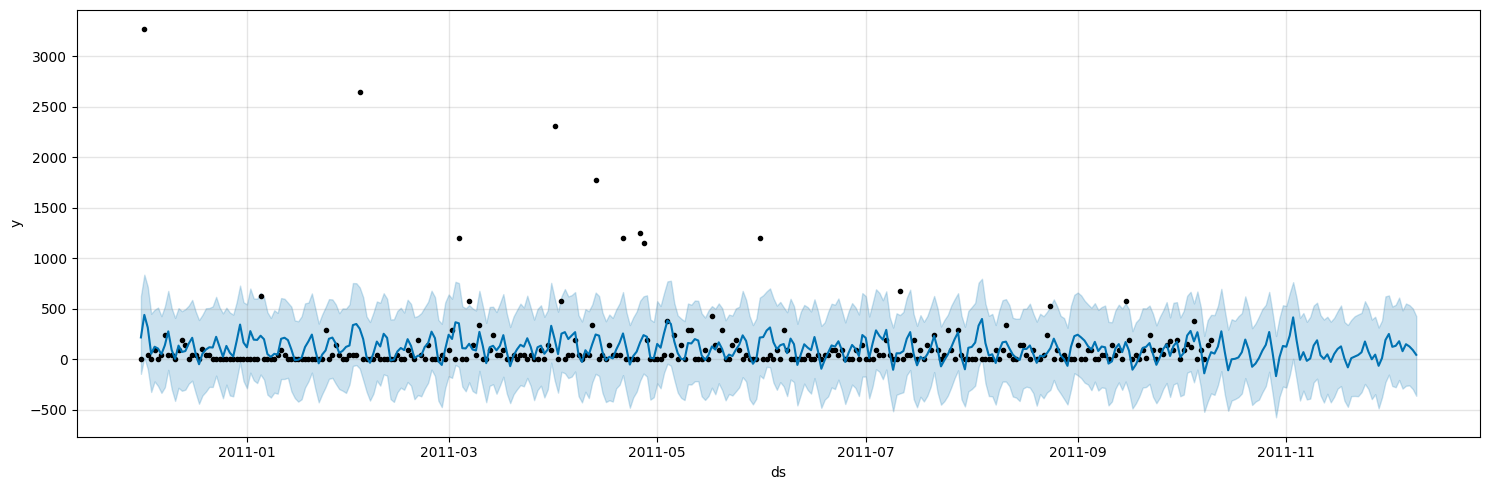

In [26]:
fig3 = m2_p0.plot(forecast2, uncertainty=True, figsize=(15,5))

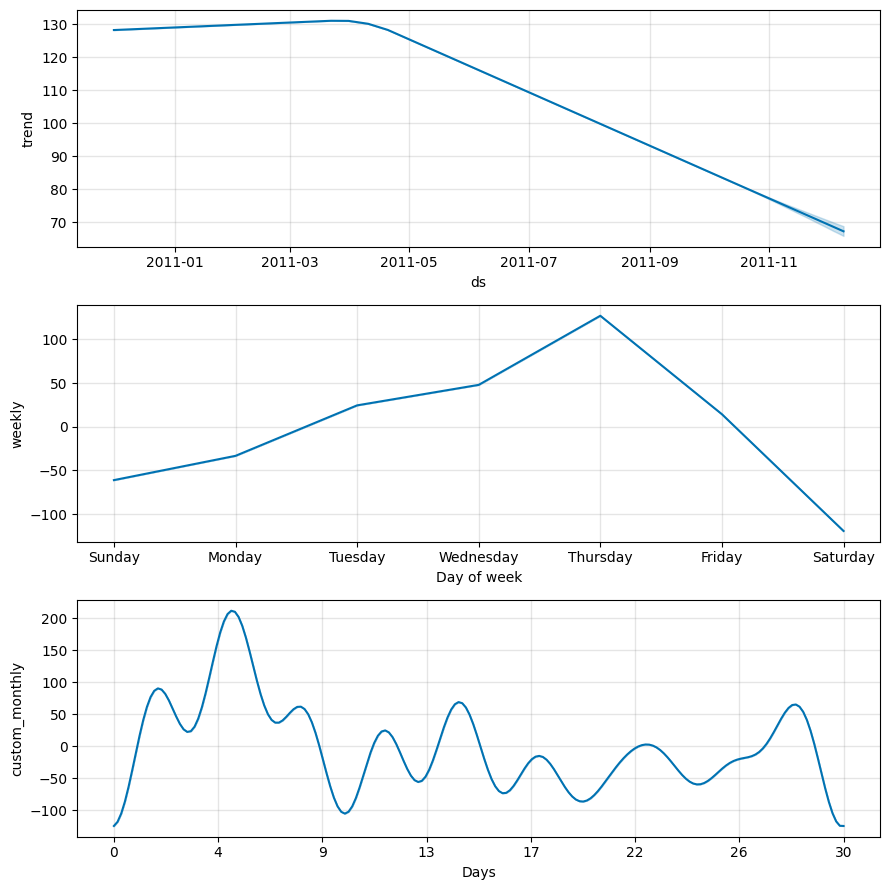

In [24]:
fig4 = m2_p0.plot_components(forecast2)

In [25]:
# RMSE
rmse_2 = round(rmse(forecast2.iloc[-60:]['yhat'], df_p0_test['y']),4)
rmse_2

604.1218

# Hyperparameter tuning

In [85]:
import itertools

cutoffs = pd.to_datetime(['2011-02-15', '2011-08-15', '2011-10-15'])

param_grid = {
    'changepoint_prior_scale': [0.005, 0.01, 0.05, 0.5, 1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'changepoint_range': [0.8, 0.9],
    'holidays_prior_scale': [0.005, 0.01, 0.05, 0.5, 1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'seasonality_mode': ['multiplicative', 'additive']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m3 = Prophet(**params).fit(df_p0)  # Fit model with given params
    df3_p0_cv = cross_validation(m3,  initial='180 days', period='180 days', horizon = '90 days', parallel="processes")
    df3_p0_p = performance_metrics(df3_p0_cv, rolling_window=1)
    rmses.append(df3_p0_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

18:52:35 - cmdstanpy - INFO - Chain [1] start processing
18:52:35 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
18:52:36 - cmdstanpy - INFO - Chain [1] start processing
18:52:36 - cmdstanpy - INFO - Chain [1] done processing
18:52:36 - cmdstanpy - INFO - Chain [1] start processing
18:52:36 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
18:52:36 - cmdstanpy - INFO - Chain [1] start processing
18:52:36 - cmdstanpy - INFO - Chain [1] done processing
18:52:36 - cmdstanpy - INFO - Chain [1] start processing
18:52:36 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactive plots will not work.
18:52:37 - cmdstanpy - INFO - Chain [1] start processing
18:52:37 - cmdstanpy - INFO - Chain [1] done processing
18:52:37 - cmdstanpy - INFO - Chain [1] start processing
18:52:37 - cmdstanpy - INFO - Chain [1] done processing
Importing plotly failed. Interactiv

KeyboardInterrupt: 

# Prophet model the Top 1 product

Helpful resource: https://facebook.github.io/prophet/docs/quick_start.html

Regarding the train/test split:
- my dataset has 375 days
- I will use the last part of the dataset as my test model, and I nned to define the number of days that I will consider
- 80% of my dataset is 83 days, and 90% 46.5 days
- since I have a bit more than 12 months of data, I can consider the first 10 months as my train set, and the last 2 months as the test set.

That means that my test set will have the last 60 days, and thus my train set the first 315 days.

### **Top 1 product, no clusters, no outlier clipping**

### Prophet model for the top products

In [10]:
prophet_model_per_product(df, products_top[0],0)

18:54:05 - cmdstanpy - INFO - Chain [1] start processing
18:54:05 - cmdstanpy - INFO - Chain [1] done processing


Instances that needed outlier clipping:  10 , out of total instances:  424


Top 1 product, no clusters, no outlier clipping:
Root Mean Squared Error:  609.3749
Mean Absolute Error:  155.5281


Top 1 product, no clusters, with outlier clipping:
Root Mean Squared Error:  167.2127
Mean Absolute Error:  90.9965


Top 1 product, no clusters, with outlier clipping, metrics compared to test set without clipping:
Root Mean Squared Error:  614.8361
Mean Absolute Error:  152.1632


Top 1 product, with clusters, no outlier clipping:
Cluster 0:
Root Mean Squared Error:  32.3399
Mean Absolute Error:  22.4198
Cluster 1:
Root Mean Squared Error:  61.8408
Mean Absolute Error:  45.6321
Cluster 2:
Root Mean Squared Error:  75.5434
Mean Absolute Error:  45.3511
Cluster 3:
Root Mean Squared Error:  610.0817
Mean Absolute Error:  117.1422

Collective metrics for this model:
RMSE:  108.8987 , MAE:  48.5807


Top 1 product, with clusters, with outlier clipping:
Instances that needed outlier clipping:  0 , o

In [11]:
prophet_model_per_product(df, products_top[1],1)

Instances that needed outlier clipping:  9 , out of total instances:  965


Top 2 product, no clusters, no outlier clipping:
Root Mean Squared Error:  487.9998
Mean Absolute Error:  235.3251


Top 2 product, no clusters, with outlier clipping:
Root Mean Squared Error:  285.3265
Mean Absolute Error:  173.0273


Top 2 product, no clusters, with outlier clipping, metrics compared to test set without clipping:
Root Mean Squared Error:  503.4385
Mean Absolute Error:  233.3273


Top 2 product, with clusters, no outlier clipping:
Cluster 0:
Root Mean Squared Error:  16.1218
Mean Absolute Error:  7.7057
Cluster 1:
Root Mean Squared Error:  70.1693
Mean Absolute Error:  44.1573
Cluster 2:
Root Mean Squared Error:  126.4374
Mean Absolute Error:  70.9576
Cluster 3:
Root Mean Squared Error:  456.1989
Mean Absolute Error:  180.3268

Collective metrics for this model:
RMSE:  121.9279 , MAE:  61.9183


Top 2 product, with clusters, with outlier clipping:
Instances that needed outlier clipping:  2 , o

In [12]:
prophet_model_per_product(df, products_top[2],2)

Instances that needed outlier clipping:  20 , out of total instances:  1461


Top 3 product, no clusters, no outlier clipping:
Root Mean Squared Error:  181.4184
Mean Absolute Error:  126.0656


Top 3 product, no clusters, with outlier clipping:
Root Mean Squared Error:  124.9884
Mean Absolute Error:  96.5427


Top 3 product, no clusters, with outlier clipping, metrics compared to test set without clipping:
Root Mean Squared Error:  182.8239
Mean Absolute Error:  118.6261


Top 3 product, with clusters, no outlier clipping:
Cluster 0:
Root Mean Squared Error:  9.1556
Mean Absolute Error:  6.21
Cluster 1:
Root Mean Squared Error:  42.1611
Mean Absolute Error:  23.6922
Cluster 2:
Root Mean Squared Error:  35.8415
Mean Absolute Error:  31.9379
Cluster 3:
Root Mean Squared Error:  175.9105
Mean Absolute Error:  109.778

Collective metrics for this model:
RMSE:  54.0092 , MAE:  35.7845


Top 3 product, with clusters, with outlier clipping:
Instances that needed outlier clipping:  1 , out of

In [13]:
prophet_model_per_product(df, products_top[3],3)

Instances that needed outlier clipping:  12 , out of total instances:  1936


Top 4 product, no clusters, no outlier clipping:
Root Mean Squared Error:  177.4483
Mean Absolute Error:  91.3589


Top 4 product, no clusters, with outlier clipping:
Root Mean Squared Error:  93.7371
Mean Absolute Error:  63.552


Top 4 product, no clusters, with outlier clipping, metrics compared to test set without clipping:
Root Mean Squared Error:  172.0019
Mean Absolute Error:  77.9187


Top 4 product, with clusters, no outlier clipping:
Cluster 0:
Root Mean Squared Error:  11.8713
Mean Absolute Error:  8.794
Cluster 1:
Root Mean Squared Error:  27.3009
Mean Absolute Error:  19.7023
Cluster 2:
Root Mean Squared Error:  28.0888
Mean Absolute Error:  19.8685
Cluster 3:
Root Mean Squared Error:  169.628
Mean Absolute Error:  70.0236

Collective metrics for this model:
RMSE:  35.4052 , MAE:  21.3707


Top 4 product, with clusters, with outlier clipping:
Instances that needed outlier clipping:  14 , out of t

In [14]:
prophet_model_per_product(df, products_top[4],4)

Instances that needed outlier clipping:  4 , out of total instances:  1320


Top 5 product, no clusters, no outlier clipping:
Root Mean Squared Error:  189.1148
Mean Absolute Error:  94.8089


Top 5 product, no clusters, with outlier clipping:
Root Mean Squared Error:  113.7963
Mean Absolute Error:  71.341


Top 5 product, no clusters, with outlier clipping, metrics compared to test set without clipping:
Root Mean Squared Error:  189.8075
Mean Absolute Error:  86.241


Top 5 product, with clusters, no outlier clipping:
Cluster 0:
Root Mean Squared Error:  19.6208
Mean Absolute Error:  13.1934
Cluster 1:
Root Mean Squared Error:  47.4772
Mean Absolute Error:  29.6143
Cluster 2:
Root Mean Squared Error:  61.1003
Mean Absolute Error:  36.3581
Cluster 3:
Root Mean Squared Error:  163.2501
Mean Absolute Error:  64.3185

Collective metrics for this model:
RMSE:  48.3893 , MAE:  28.705


Top 5 product, with clusters, with outlier clipping:
Instances that needed outlier clipping:  6 , out of t

In [15]:
prophet_model_per_product(df, products_top[9],9)

Instances that needed outlier clipping:  10 , out of total instances:  596


Top 10 product, no clusters, no outlier clipping:
Root Mean Squared Error:  73.4211
Mean Absolute Error:  64.8493


Top 10 product, no clusters, with outlier clipping:
Root Mean Squared Error:  55.4825
Mean Absolute Error:  49.5311


Top 10 product, no clusters, with outlier clipping, metrics compared to test set without clipping:
Root Mean Squared Error:  55.4825
Mean Absolute Error:  49.5311


Top 10 product, with clusters, no outlier clipping:
Cluster 0:
Root Mean Squared Error:  6.2262
Mean Absolute Error:  4.8704
Cluster 1:
Root Mean Squared Error:  16.7243
Mean Absolute Error:  13.083
Cluster 2:
Root Mean Squared Error:  24.697
Mean Absolute Error:  14.5475
Cluster 3:
Root Mean Squared Error:  63.8144
Mean Absolute Error:  58.7338

Collective metrics for this model:
RMSE:  21.9857 , MAE:  16.7423


Top 10 product, with clusters, with outlier clipping:
Instances that needed outlier clipping:  0 , out of t

In [16]:
prophet_model_per_product(df, products_top[19],19)

Instances that needed outlier clipping:  5 , out of total instances:  209


Top 20 product, no clusters, no outlier clipping:
Root Mean Squared Error:  45.9684
Mean Absolute Error:  37.005


Top 20 product, no clusters, with outlier clipping:
Root Mean Squared Error:  34.7791
Mean Absolute Error:  24.7426


Top 20 product, no clusters, with outlier clipping, metrics compared to test set without clipping:
Root Mean Squared Error:  34.7791
Mean Absolute Error:  24.7426


Top 20 product, with clusters, no outlier clipping:
Cluster 0:
Root Mean Squared Error:  14.2807
Mean Absolute Error:  8.2942
Cluster 1:
Root Mean Squared Error:  20.1651
Mean Absolute Error:  14.2544
Cluster 2:
Root Mean Squared Error:  21.0183
Mean Absolute Error:  7.2714
Cluster 3:
Root Mean Squared Error:  30.3176
Mean Absolute Error:  28.7206

Collective metrics for this model:
RMSE:  19.5181 , MAE:  12.408


Top 20 product, with clusters, with outlier clipping:
Instances that needed outlier clipping:  1 , out of to

In [17]:
prophet_model_per_product(df, products_top[49],49)

Instances that needed outlier clipping:  36 , out of total instances:  715


Top 50 product, no clusters, no outlier clipping:
Root Mean Squared Error:  56.6367
Mean Absolute Error:  49.3062


Top 50 product, no clusters, with outlier clipping:
Root Mean Squared Error:  46.1425
Mean Absolute Error:  41.9781


Top 50 product, no clusters, with outlier clipping, metrics compared to test set without clipping:
Root Mean Squared Error:  54.9144
Mean Absolute Error:  46.4115


Top 50 product, with clusters, no outlier clipping:
Cluster 0:
Root Mean Squared Error:  3.8512
Mean Absolute Error:  2.9223
Cluster 1:
Root Mean Squared Error:  12.895
Mean Absolute Error:  10.9831
Cluster 2:
Root Mean Squared Error:  22.3658
Mean Absolute Error:  20.3962
Cluster 3:
Root Mean Squared Error:  45.6956
Mean Absolute Error:  25.7902

Collective metrics for this model:
RMSE:  17.73 , MAE:  14.5228


Top 50 product, with clusters, with outlier clipping:
Instances that needed outlier clipping:  0 , out of to

# Plots for presentation

In [18]:
forecast0, m0, test0 = prophet_model_per_product_SELECTED_MODEL_returns_forecast(df, products_top[2],2)

Instances that needed outlier clipping:  20 , out of total instances:  1461


Top 3 product, no clusters, with outlier clipping, metrics compared to test set without clipping:
Root Mean Squared Error:  182.8239
Mean Absolute Error:  118.6261


/var/folders/yt/xx6_vt592x9cgxz0trzlfxp00000gn/T/ipykernel_38099/1047135329.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(test0['ds'], test0['y'], 'ro-', label='Actual Values (Test Set)', color='#3CBDBB')  # Red color


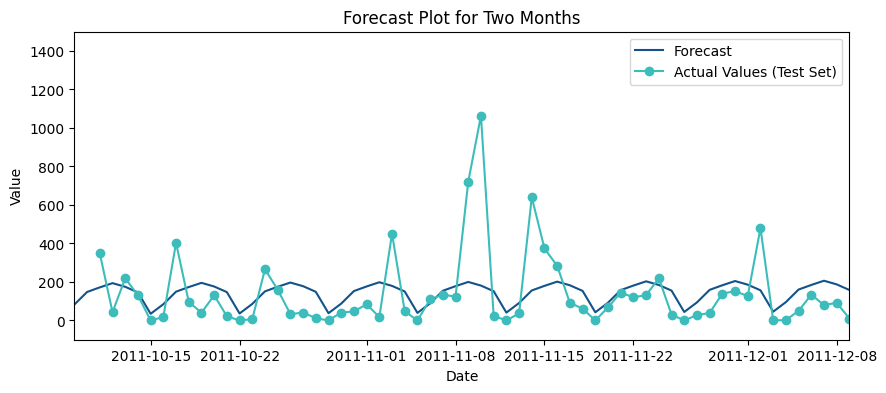

In [19]:
import matplotlib.pyplot as plt

# Plot the forecast for two months
plt.figure(figsize=(10, 4))
plt.plot(forecast0['ds'], forecast0['yhat'], label='Forecast', color='#13538A')  # Blue color

# Plot the actual values from the test set
plt.plot(test0['ds'], test0['y'], 'ro-', label='Actual Values (Test Set)', color='#3CBDBB')  # Red color

# Set axis labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Forecast Plot for Two Months')

# Set the x-axis limits for one month
plt.xlim(pd.Timestamp('2011-10-09'), pd.Timestamp('2011-12-09'))
plt.ylim(-100, 1500) 

# Show legend
plt.legend()
plt.savefig('../images/forecast_plot0.png')
# Show plot
plt.show()


In [20]:
forecast1, m1, test1,forecast2, m2, test2,forecast3, m3, test3,forecast4, m4, test4 = prophet_model_per_product_CLUSTER_SELECTED_MODEL_returns_forecast(df, products_top[2],2)

Instances that needed outlier clipping:  20 , out of total instances:  1461


Top 3 product, with clusters, with outlier clipping, metrics compared to test set without clipping:
Instances that needed outlier clipping:  1 , out of total instances:  157
Instances that needed outlier clipping:  17 , out of total instances:  631
Instances that needed outlier clipping:  8 , out of total instances:  482
Instances that needed outlier clipping:  3 , out of total instances:  191
Cluster 0:
Root Mean Squared Error:  9.0399
Mean Absolute Error:  6.1829
Cluster 1:
Root Mean Squared Error:  42.4848
Mean Absolute Error:  23.1539
Cluster 2:
Root Mean Squared Error:  32.1045
Mean Absolute Error:  27.2332
Cluster 3:
Root Mean Squared Error:  177.9123
Mean Absolute Error:  106.1644

Collective metrics for this model:
RMSE:  0.0 , MAE:  0.0


In [21]:
label_percentages = [round((df[(df.StockCode==products_top[0])&(df.Label==i)].shape[0]/
                          df[df.StockCode==products_top[0]].shape[0])*100,2) for i in range(4)]
label_percentages

[13.92, 53.3, 24.06, 8.73]

In [22]:
forecast_total_0 = forecast1.copy()
forecast_total_0['yhat'] = forecast1['yhat']*0.1392 +forecast2['yhat']*0.533+forecast3['yhat']*0.2406+forecast4['yhat']*0.873

test_total_0 = test1.copy()
test_total_0['y'] = test1['y']*0.1392 +test2['y']*0.533+test3['y']*0.2406+test4['y']*0.873

/var/folders/yt/xx6_vt592x9cgxz0trzlfxp00000gn/T/ipykernel_38099/2143612773.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(test0['ds'], test0['y'], 'ro-', label='Actual Values (Test Set)', color='#3CBDBB')  # Red color


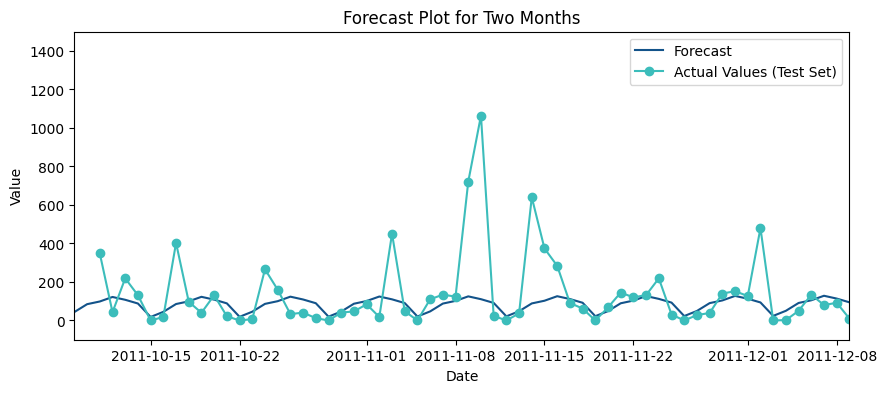

In [23]:
import matplotlib.pyplot as plt

# Plot the forecast for two months
plt.figure(figsize=(10, 4))
plt.plot(forecast_total_0['ds'], forecast_total_0['yhat'], label='Forecast', color='#13538A')  # Blue color

# Plot the actual values from the test set
plt.plot(test0['ds'], test0['y'], 'ro-', label='Actual Values (Test Set)', color='#3CBDBB')  # Red color

# Set axis labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Forecast Plot for Two Months')

# Set the x-axis limits for one month
plt.xlim(pd.Timestamp('2011-10-09'), pd.Timestamp('2011-12-09'))
plt.ylim(-100, 1500) 

# Show legend
plt.legend()
plt.savefig('../images/forecast_plot1.png')
# Show plot
plt.show()


In [26]:
# Saving model
with open('../models/forecast_model_cl1.pkl', 'wb') as f:
    pickle.dump(forecast1, f)